# Prediciting Evolutionary Dynamics of Microbial Systems with  Reinforcement Learning and Dynamic Flux Balance Analysis



## Overal View of the Algorithm

![img](Process.svg)

### Step 1: Define the Constants and Load The Toy Networks

In [1]:
NUMBER_OF_BATCHES=100
BATCH_SIZE=8
HIDDEN_SIZE=30
PERCENTILE=70

import os 
import datetime
import numpy as np
import cobra
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import pickle
import pandas
#import cplex
from ToyModel import  Toy_Model_NE_1,Toy_Model_NE_2
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple
import ray
from sklearn.preprocessing import StandardScaler
from tensorboardX import SummaryWriter
from heapq import heappop, heappush

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


### Then we have to define a number of classes, objects, and functions that will be used during the simulations!

In [2]:
Scaler=StandardScaler()
CORES = multiprocessing.cpu_count()
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])
Main_dir = os.path.dirname(".")
torch.manual_seed(0)

class ProrityQueue:
    
    def __init__(self,N):
        self.N=N
        self.Elements=[]
    
    def enqueue_with_priority(self,Step):
        Element = (-Step[0], random.random(),Step[1],Step[2])
        heappush(self.Elements, Element)

    def dequeue(self):
        heappop(self.Elements)
    
    def balance(self):
        while len(self.Elements)>=self.N:
            self.dequeue()
    
    
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, n_actions),
            
        )

    def forward(self, x):
        return self.net(x)



### Definition of DFBA function

In [4]:
@ray.remote
def dFBA(Models, Mapping_Dict: dict, Init_C:np.ndarray, Params:dict, t_span:list, dt=0.1)->list:
    """
    This function calculates the concentration of each species
    Models is a list of COBRA Model objects
    Mapping_Dict is a dictionary of dictionaries
    """
    ##############################################################
    # Initializing the ODE Solver
    ##############################################################
    t = np.arange(t_span[0], t_span[1], dt)
    ##############################################################
    # Solving the ODE
    ##############################################################
    for m in Models:
        m.episode_reward=0
        m.episode_steps=[]
    
    sol, t = odeFwdEuler(ODE_System, Init_C, dt,  Params,
                         t_span, Models, Mapping_Dict)
    
    for m in Models:
        m.Episode=Episode(reward=m.episode_reward, steps=m.episode_steps)




    return [m.Episode for m in Models]


def ODE_System(C, t, Models, Mapping_Dict, Params, dt):
    """
    This function calculates the differential equations for the system
    Models is a list of COBRA Model objects
    NOTE: this implementation of DFBA is compatible with RL framework
    Given a policy it will genrate episodes. Policies can be either deterministic or stochastic
    Differential Equations Are Formatted as follows:
    [0]-Models[1]
    [1]-Models[2]
    []-...
    [n-1]-Models[n]
    [n]-Exc[1]
    [n+1]-Exc[2]
    []-...
    [n+m-1]-Exc[m]
    [n+m]-Starch
    """
    C[C < 0] = 0
    dCdt = np.zeros(C.shape)
    Sols = list([0 for i in range(Models.__len__())])
    for i,M in enumerate(Models):
        
        if random.random()<M.epsilon:

            M.a=M.Policy(torch.FloatTensor([C[M.observables]])).detach().numpy()[0]*(1-M.epsilon)+np.random.uniform(low=-0.2, high=0.2,size=len(M.actions))*M.epsilon
        
        else:

            M.a=M.Policy(torch.FloatTensor([C[M.observables]])).detach().numpy()[0]
        
        for index,item in enumerate(Mapping_Dict["Ex_sp"]):
            if Mapping_Dict['Mapping_Matrix'][index,i]!=-1:
                M.reactions[Mapping_Dict['Mapping_Matrix'][index,i]].upper_bound=20
                M.reactions[Mapping_Dict['Mapping_Matrix'][index,i]].lower_bound=-General_Uptake_Kinetics(C[index+len(Models)])
                
            
        for index,flux in enumerate(M.actions):
            M.a[index]=Flux_Clipper(M.reactions[M.actions[index]].lower_bound,M.a[index],M.reactions[M.actions[index]].upper_bound)
            M.reactions[M.actions[index]].lower_bound=M.a[index]
            # M.reactions[M.actions[index]].upper_bound=M.a[index]

        Sols[i] = Models[i].optimize()

        if Sols[i].status == 'infeasible':
            Models[i].reward= -10
            dCdt[i] = 0

        else:
            dCdt[i] += Sols[i].objective_value*C[i]
            Models[i].reward =Sols[i].objective_value



    ### Writing the balance equations

    for i in range(Mapping_Dict["Mapping_Matrix"].shape[0]):
        for j in range(len(Models)):
            if Mapping_Dict["Mapping_Matrix"][i, j] != -1:
                if Sols[j].status == 'infeasible':
                    dCdt[i] = 0
                else:
                    dCdt[i+len(Models)] += Sols[j].fluxes.iloc[Mapping_Dict["Mapping_Matrix"]
                                                                    [i, j]]*C[j]


    for m in Models:
        m.episode_reward += m.reward
        m.episode_steps.append(EpisodeStep(observation=C[m.observables], action=m.a))
    
    dCdt += np.array(Params["Dilution_Rate"])*(Params["Inlet_C"]-C)
    
    return dCdt

### Now we need some utility functions!

In [5]:
def Build_Mapping_Matrix(Models):
    """
    Given a list of COBRA model objects, this function will build a mapping matrix

    """

    Ex_sp = []
    Temp_Map={}
    for model in Models:
        
        
        if not hasattr(model,"Biomass_Ind"):
            raise Exception("Models must have 'Biomass_Ind' attribute in order for the DFBA to work properly!")
        
        
        for Ex_rxn in model.exchanges :
            if Ex_rxn!=model.reactions[model.Biomass_Ind]:
                if list(Ex_rxn.metabolites.keys())[0].id not in Ex_sp:
                    Ex_sp.append(list(Ex_rxn.metabolites.keys())[0].id)
                if list(Ex_rxn.metabolites.keys())[0].id in Temp_Map.keys():
                   Temp_Map[list(Ex_rxn.metabolites.keys())[0].id][model]=Ex_rxn
                else:
                     Temp_Map[list(Ex_rxn.metabolites.keys())[0].id]={model:Ex_rxn}

    Mapping_Matrix = np.zeros((len(Ex_sp), len(Models)), dtype=int)
    for i, id in enumerate(Ex_sp):
        for j, model in enumerate(Models):
            if model in Temp_Map[id].keys():
                Mapping_Matrix[i, j] = model.reactions.index(Temp_Map[id][model].id)
            else:
                Mapping_Matrix[i, j] = -1
    return {"Ex_sp": Ex_sp, "Mapping_Matrix": Mapping_Matrix}




def General_Uptake_Kinetics(Compound: float, Model=""):
    """
    This function calculates the rate of uptake of a compound in the reactor
    ###It is just a simple imaginary model: Replace it with better model if necessary###
    Compound Unit: mmol

    """
    return 10*(Compound/(Compound+20))





def odeFwdEuler(ODE_Function, ICs, dt, Params, t_span, Models, Mapping_Dict):
    Integrator_Counter = 0
    t = np.arange(t_span[0], t_span[1], dt)
    sol = np.zeros((len(t), len(ICs)))
    sol[0] = ICs
    for i in range(1, len(t)):
        sol[i] = sol[i-1] + \
            ODE_Function(sol[i-1], t[i-1], Models, Mapping_Dict,
                         Params, dt)*dt
        Integrator_Counter += 1
    return sol, t


def Generate_Batch(dFBA, Params, Init_C, Models, Mapping_Dict, Batch_Size=10,t_span=[0, 100], dt=0.1):


    Init_C[list(Params["Env_States"])] = [random.uniform(Range[0], Range[1]) for Range in Params["Env_States_Initial_Ranges"]]
    

    
    Batch_Episodes=[]
    for BATCH in range(Batch_Size):
        Batch_Episodes.append(dFBA.remote(Models, Mapping_Dict, Init_C, Params, t_span, dt=dt))
        # Batch_Episodes.append(dFBA(Models, Mapping_Dict, Init_C, Params, t_span, dt=dt))

    return(ray.get(Batch_Episodes))    

    # return(Batch_Episodes)    


def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))

    train_obs = []
    train_act = []
    for example in batch:
        if example.reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, example.steps))
        train_act.extend(map(lambda step: step.action, example.steps))

    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.FloatTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean


def Flux_Clipper(Min,Number,Max):
    return(min(max(Min,Number),Max))

### We now define the high level main function that controls every part of the code

In [6]:
def main(Models: list = [Toy_Model_NE_1.copy(), Toy_Model_NE_2.copy()], max_time: int = 100, Dil_Rate: float = 0.000000001, alpha: float = 0.01, Starting_Q: str = "FBA")->None:
    """
    This is the main function for running dFBA.
    The main requrement for working properly is
    that the models use the same notation for the
    same reactions.

    Starting_Policy:

    Defult --> Random: Initial Policy will be a random policy for all agents.
    Otherwise --> a list of policies, pickle file addresses, for each agent.


    """
    # Adding Agents info ###-----------------------------------------------------

    # State dimensions in this RLDFBA variant include: [Agent1,...,Agentn, glucose,starch]
    for i in range(len(Models)):
        if not hasattr(Models[i], "_name"):
            Models[i].NAME = "Agent_" + str(i)
            print(f"Agent {i} has been given a defult name")
        Models[i].solver.objective.name = "_pfba_objective"
    # -------------------------------------------------------------------------------

    # Mapping internal reactions to external reactions, and operational parameter
    # setup ###-------------------------------------------------------------------

    # For more information about the structure of the ODEs,see ODE_System function
    # or the documentation.

    Mapping_Dict = Build_Mapping_Matrix(Models)
    Init_C = np.ones((len(Models)+len(Mapping_Dict["Ex_sp"]),))
    Inlet_C = np.zeros((len(Models)+len(Mapping_Dict["Ex_sp"]),))

    #Parameters that are use inside DFBA

    Params = {
        "Dilution_Rate": Dil_Rate,
        "Inlet_C": Inlet_C,
        "Agents_Index": [i for i in range(len(Models))],
    }

    #Define Agent attributes
    Obs=[i for i in range(len(Models))]
    Obs.extend([Mapping_Dict["Ex_sp"].index(sp)+len(Models) for sp in Mapping_Dict["Ex_sp"] if sp!='P' ])
    for ind,m in enumerate(Models):
        m.observables=Obs
        m.actions=(Mapping_Dict["Mapping_Matrix"][Mapping_Dict["Ex_sp"].index("A"),ind],Mapping_Dict["Mapping_Matrix"][Mapping_Dict["Ex_sp"].index("B"),ind])
        m.Policy=Net(len(m.observables), HIDDEN_SIZE, len(m.actions))
        m.optimizer=optim.SGD(params=m.Policy.parameters(), lr=0.01)
        m.Net_Obj=nn.MSELoss()
        m.epsilon=0.05
        
    ### I Assume that the environment states are all observable. Env states will be stochastic
    Params["Env_States"]=Models[0].observables
    Params["Env_States_Initial_Ranges"]=[[0.1,0.1+0.00000001],[0.1,0.1+0.00000001],[100,100+0.00001],[1,0.001+0.00000000001],[1,0.001+0.00000000001]]
    for i in range(len(Models)):
        Init_C[i] = 0.001
        #Models[i].solver = "cplex"
    writer = SummaryWriter(comment="-DeepRLDFBA_NECOM")
    Outer_Counter = 0


    for c in range(NUMBER_OF_BATCHES):
        for m in Models:
            m.epsilon=0.01+0.99/(np.exp(c/20))
        Batch_Out=Generate_Batch(dFBA, Params, Init_C, Models, Mapping_Dict,Batch_Size=BATCH_SIZE)
        Batch_Out=list(map(list, zip(*Batch_Out)))
        for index,Model in enumerate(Models):
            obs_v, acts_v, reward_b, reward_m=filter_batch(Batch_Out[index], PERCENTILE)
            Model.optimizer.zero_grad()
            action_scores_v = Model.Policy(obs_v)
            loss_v = Model.Net_Obj(action_scores_v, acts_v)
            loss_v.backward()
            Model.optimizer.step()
            print(f"{Model.NAME}")
            print("%d: loss=%.3f, reward_mean=%.1f, reward_bound=%.1f" % (c, loss_v.item(), reward_m, reward_b))

            writer.add_scalar(f"{Model.NAME} reward_mean", reward_m, c)
    
    Time=datetime.datetime.now().strftime("%d_%m_%Y.%H_%M_%S")
    Results_Dir=os.path.join(Main_dir,"Outputs",str(Time))
    os.mkdir(Results_Dir)
    with open(os.path.join(Results_Dir,"Models.pkl"),'wb') as f:
        pickle.dump(Models,f)
    return Models

### Finally it's time to run!!!

In [7]:
ray.init()
Models=main([Toy_Model_NE_1.copy(),Toy_Model_NE_2.copy()])

Agent 0 has been given a defult name
Agent 1 has been given a defult name


(dFBA pid=37371) /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/ipykernel_37349/47650564.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1656352453927/work/torch/csrc/utils/tensor_new.cpp:204.)
(dFBA pid=37373) /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/ipykernel_37349/47650564.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1656352453927/work/torch/csrc/utils/tensor_new.cpp:204.)
(dFBA pid=37377) /var/folders/jk/fr50qn391k794svhntbw333c0000gn/T/ipykernel_37349/47650564.py:55: UserWarning: Creating a tensor from a list of numpy.

Agent_0
0: loss=0.023, reward_mean=-4953.6, reward_bound=-4840.8
Agent_1
0: loss=0.032, reward_mean=-4859.8, reward_bound=-4730.8
Agent_0
1: loss=0.021, reward_mean=-4528.7, reward_bound=-4449.9
Agent_1
1: loss=0.030, reward_mean=-4599.8, reward_bound=-4504.8
Agent_0
2: loss=0.015, reward_mean=-4093.6, reward_bound=-3992.9
Agent_1
2: loss=0.023, reward_mean=-4392.4, reward_bound=-4281.9
Agent_0
3: loss=0.015, reward_mean=-3858.7, reward_bound=-3822.9
Agent_1
3: loss=0.021, reward_mean=-4049.8, reward_bound=-3968.8
Agent_0
4: loss=0.011, reward_mean=-3606.0, reward_bound=-3584.8
Agent_1
4: loss=0.015, reward_mean=-3656.1, reward_bound=-3607.9
Agent_0
5: loss=0.012, reward_mean=-3266.2, reward_bound=-3217.9
Agent_1
5: loss=0.019, reward_mean=-3584.8, reward_bound=-3529.8
Agent_0
6: loss=0.009, reward_mean=-2884.9, reward_bound=-2756.9
Agent_1
6: loss=0.014, reward_mean=-3393.6, reward_bound=-3328.8
Agent_0
7: loss=0.008, reward_mean=-2683.6, reward_bound=-2627.9
Agent_1
7: loss=0.012, re

Agent_0
68: loss=0.001, reward_mean=0.0, reward_bound=0.0
Agent_1
68: loss=0.001, reward_mean=0.2, reward_bound=0.2
Agent_0
69: loss=0.000, reward_mean=0.1, reward_bound=0.1
Agent_1
69: loss=0.001, reward_mean=0.2, reward_bound=0.2
Agent_0
70: loss=0.001, reward_mean=0.0, reward_bound=0.0
Agent_1
70: loss=0.001, reward_mean=0.2, reward_bound=0.2
Agent_0
71: loss=0.000, reward_mean=0.1, reward_bound=0.1
Agent_1
71: loss=0.000, reward_mean=0.2, reward_bound=0.2
Agent_0
72: loss=0.000, reward_mean=0.0, reward_bound=0.0
Agent_1
72: loss=0.001, reward_mean=0.2, reward_bound=0.2
Agent_0
73: loss=0.001, reward_mean=0.0, reward_bound=0.0
Agent_1
73: loss=0.002, reward_mean=0.2, reward_bound=0.2
Agent_0
74: loss=0.000, reward_mean=0.1, reward_bound=0.1
Agent_1
74: loss=0.000, reward_mean=0.2, reward_bound=0.2
Agent_0
75: loss=0.000, reward_mean=0.1, reward_bound=0.1
Agent_1
75: loss=0.001, reward_mean=0.2, reward_bound=0.2
Agent_0
76: loss=0.000, reward_mean=0.1, reward_bound=0.1
Agent_1
76: lo

## Step n: Plotting the policy

Observation space of each agent **in this particular example** is similar and contains 5 different states. Our goal is to create a meshgrid dataframe that includes these states and the actions taken as columns 

In [25]:
import plotly.graph_objects as go
import pandas as pd

One way is to make a mesh grid which might be inefficient, probably is! So I won't complete it for now.

In [19]:
Ag1=np.linspace(0,10,10)
Ag2=np.linspace(0,10,10)
S=np.linspace(0,100,10)
A=np.linspace(0,10,10)
B=np.linspace(0,10,10)
Meshgrid=np.meshgrid(Ag1,Ag2,S,A,B)

A much faster way is to generate a bunch of random points in the desired mesh and input them to the policy network

In [43]:
Space_Size=10000
Space=np.random.uniform(low=[0,0,0,0,0],high=[10,10,100,10,10],size=(Space_Size,5))
Actions_1=Models[0].Policy(torch.FloatTensor(Space))
Actions_2=Models[1].Policy(torch.FloatTensor(Space))



<AxesSubplot:>

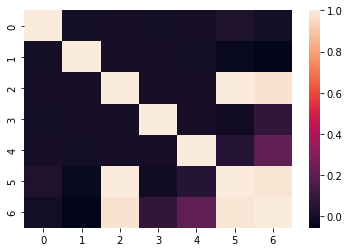

In [50]:
import seaborn as sns
sns.heatmap(pd.DataFrame(np.hstack((Space,Actions_1.detach().numpy()))).corr())